In [124]:
from data import load_housing_data
import matplotlib.pyplot as plt   
import numpy as np

In [125]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [126]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [127]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [128]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


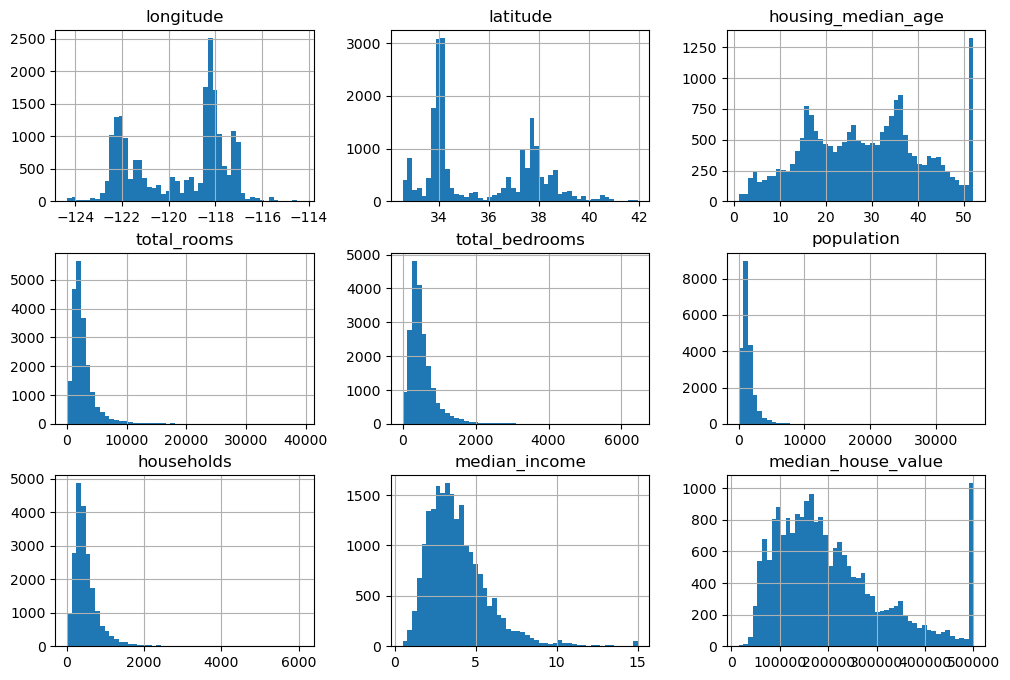

In [129]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

## Splitting the Dataset into Training and Test Sets
To ensure that our model performs well on unseen data, we need to split the dataset into training and test sets. This will allow us to train the model on one portion of the data and evaluate its performance on another portion that it has not seen before.

In [130]:
# np.random.permutation(n) : returns a new NumPy array containing a random permutation of the integers from 0 to n−1.
# len(data) computes the number of rows (or items) in data.
# So shuffled_indices is an array of all row‑indices in random order.

def shuffle_and_split_data(data, test_ratio):
       shuffled_indices = np.random.permutation(len(data))
       test_set_size = int(len(data) * test_ratio)
       test_indices = shuffled_indices[:test_set_size]
       train_indices = shuffled_indices[test_set_size:]
       return data.iloc[train_indices], data.iloc[test_indices]

In [131]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

If we run the program again, we will get another set of splits, and by doing so, we will eventually see all the data, which is not ideal.

`crc32(...)` gives you a seemingly “random” 32‑bit number based on the input bits.

By checking whether that number is below `test_ratio * 2**32`, you effectively assign approximately `test_ratio` fraction of IDs to the test set (e.g., 20% if `test_ratio = 0.2`).

Crucially, the same ID always hashes to the same checksum, so it will always go to the same split.


In [132]:
from zlib import crc32
import pandas as pd

In [133]:
# The function returns a Boolean:
# True if this particular identifier “hashes” into the test set
# False otherwise (so it remains in the training set)

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32


## Splitting a DataFrame

To split a DataFrame into training and test sets:

1. Extract your “ID” column (anything uniquely identifying a row).
2. Use `.apply(...)` to run the hash-check on every ID.
3. Use `data.loc[~in_test_set]` for the training set and `data.loc[in_test_set]` for the test set.

This ensures consistent splits across multiple runs.


In [134]:
def split_data_with_id_hash(data, test_ratio, id_column):
       ids = data[id_column]
       in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
       return data.loc[~in_test_set], data.loc[in_test_set]

In [135]:
# Every pandas DataFrame has an internal row index (by default 0, 1, 2, … N‑1).
# Calling .reset_index() takes that internal index and turns it into a regular column named "index". 
housing_with_id = housing.reset_index() 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [136]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


## visualiziation of the data 

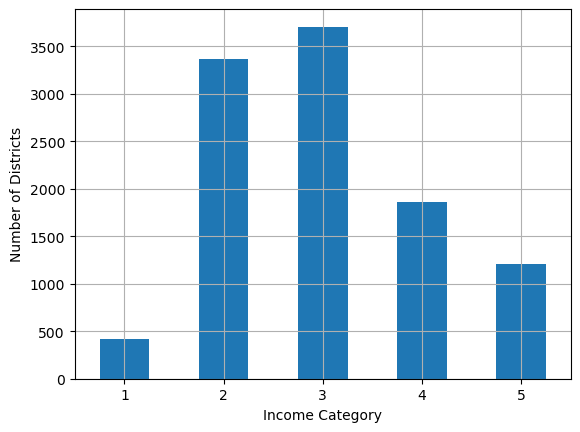

In [184]:
# pd.cut(...) : This takes a continuous variable (housing["median_income"]) and “cuts” it into discrete bins.
# .plot.bar(rot=0, grid=True)
# Draws a bar chart:
# rot=0 keeps the x‑axis labels (1, 2, 3, 4, 5) horizontal.
# grid=True adds a light grid behind the bars.
housing["income_cat"]=pd.cut(housing['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
housing.head(10)
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

scikit‑learn’s StratifiedShuffleSplit to create a stratified train/test split based on income_cat categories so that each bracket is proportionally represented.

In [185]:
from sklearn.model_selection import StratifiedShuffleSplit


In [189]:
# splitter.split(X, y) doesn’t return DataFrames; it returns an iterator of index‐arrays.
# Each time you iterate over it you get two NumPy arrays:
# train_index – an array of integer row positions that belong in the training set
# test_index – an array of integer row positions that belong in the test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
       strat_train_set_n = housing.iloc[train_index]
       strat_test_set_n = housing.iloc[test_index]
       strat_splits.append([strat_train_set_n, strat_test_set_n])

In [ ]:
# Appends a two‐element list [strat_train_set_n, strat_test_set_n] to strat_splits.
# After the loop, strat_splits[0][0] is your training DataFrame and strat_splits[0][1] is your test DataFrame.
strat_train_set, strat_test_set = strat_splits[0]

In [193]:
# This computes the proportion of each income category within your training set:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350645
2    0.318822
4    0.176269
5    0.114516
1    0.039749
Name: count, dtype: float64

In [172]:
for set_ in (strat_train_set, strat_test_set):
       set_.drop("income_cat", axis=1, inplace=True)

/var/folders/kg/zmpk852s0gn6dym0v7045yt40000gn/T/ipykernel_43689/653716026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
/var/folders/kg/zmpk852s0gn6dym0v7045yt40000gn/T/ipykernel_43689/653716026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [173]:
housing = strat_train_set.copy()

visulization the geographical data

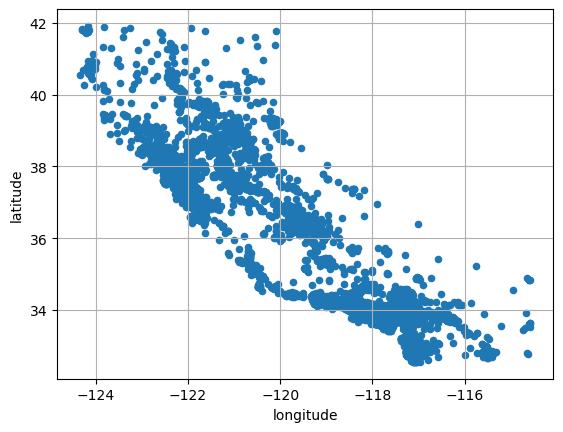

In [194]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

visulize the places to see hight density points

<Axes: xlabel='longitude', ylabel='latitude'>

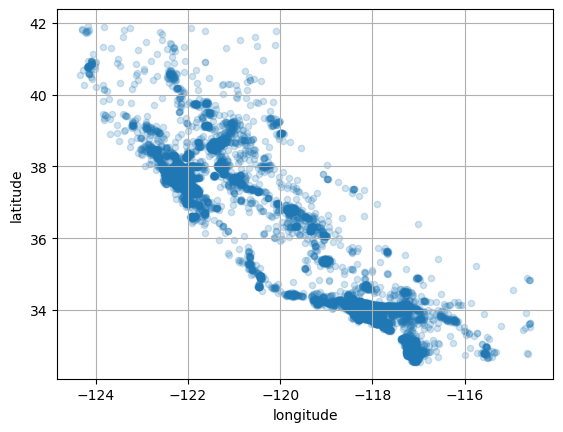

In [195]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

The radius of each circle
represents the district’s population (option s), and the color represents the
price (option c). 

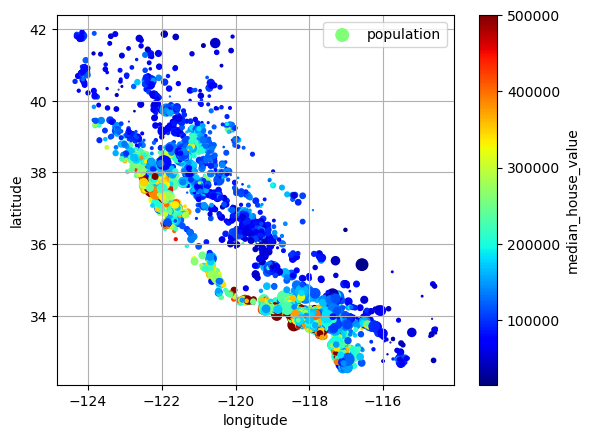

In [ ]:
# housing.plot(kind="scatter", x="longitude", y="latitude", …)
#     Chooses pandas’ built‑in plotting (which uses Matplotlib under the hood).
#     kind="scatter" makes a scatter plot with each row as one point.
#     x="longitude", y="latitude" pick those two columns for the horizontal and vertical axes—so you’re mapping geographic location.
# grid=True
#     Draws a background grid of horizontal and vertical lines to help read the plot.
# s=housing["population"] / 100
#     Controls each marker’s size.
#     By dividing the “population” column by 100, you scale down the raw counts so 
#     the points aren’t enormous. Higher‑population districts get larger dots.
# label="population"
#     Sets the label for the size legend. When you call legend=True, Matplotlib will include a legend explaining what marker size represents (“population”).
# c="median_house_value"
#     Uses the “median_house_value” column to color each point. Because these are numeric, pandas will map low values to one end of a colormap and high values to the other.
# cmap="jet"
#     Chooses the “jet” colormap (a rainbow‑style gradient) to translate numeric house values into colors.
# colorbar=True
#     Adds a colorbar beside the plot, so you can see which colors correspond to which house‐value ranges.
# legend=True
#     Shows the size legend (for population), so viewers know how dot‑size relates to number of inhabitants.
# sharex=False
#     Usually used when you have multiple subplots; here it just ensures this axes doesn’t inherit x‑limits from any others. In a single‑plot context it has no visible effect.
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"]/100, label="population", 
             c="median_house_value", cmap="jet", colorbar=True, 
             legend=True, sharex=False)
plt.show()

Now you can look at how much each attribute correlates with the median
house value:

In [177]:

# select float/double columns
num_df = housing.select_dtypes(include=[np.number])

# now compute the Pearson correlation matrix
corr_matrix = num_df.corr()
print(corr_matrix)


                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.923631           -0.101957     0.043843   
latitude            -0.923631  1.000000            0.004710    -0.032462   
housing_median_age  -0.101957  0.004710            1.000000    -0.357968   
total_rooms          0.043843 -0.032462           -0.357968     1.000000   
total_bedrooms       0.066920 -0.062162           -0.313944     0.931489   
population           0.104099 -0.111400           -0.300878     0.862849   
households           0.051542 -0.065705           -0.296725     0.915945   
median_income       -0.016428 -0.077519           -0.128176     0.190997   
median_house_value  -0.055325 -0.135712            0.101461     0.131725   

                    total_bedrooms  population  households  median_income  \
longitude                 0.066920    0.104099    0.051542      -0.016428   
latitude                 -0.062162   -0.111400   -0.065705      -0.077519   
housing_

In [178]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.684201
total_rooms           0.131725
housing_median_age    0.101461
households            0.070782
total_bedrooms        0.055016
population           -0.021700
longitude            -0.055325
latitude             -0.135712
Name: median_house_value, dtype: float64

now we using the pandas correlation matrix

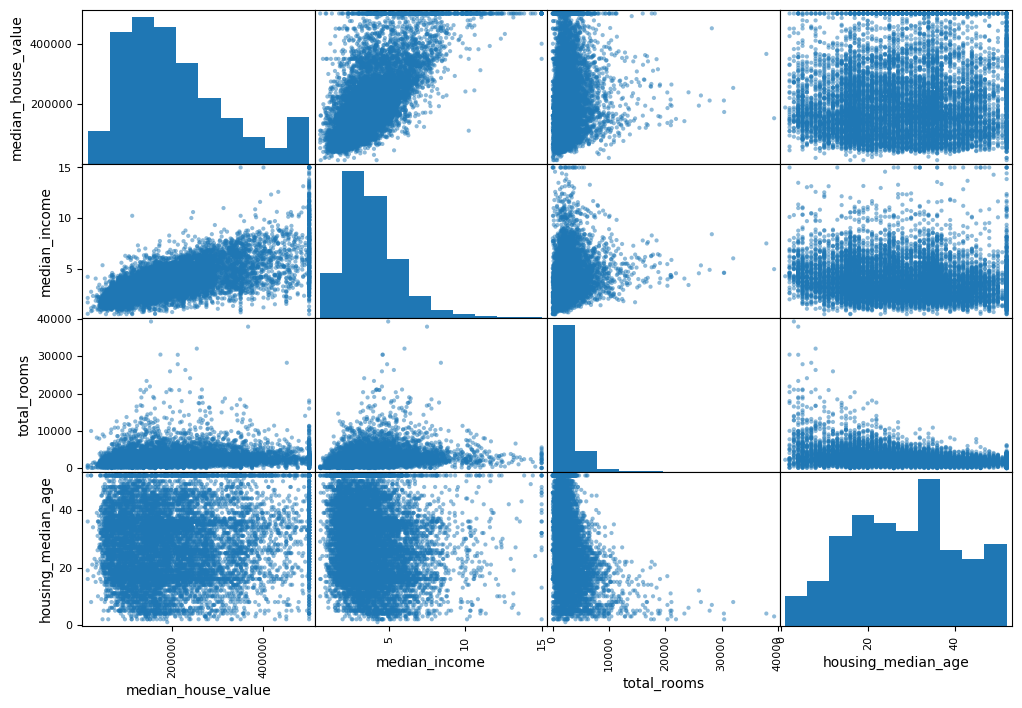

In [179]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

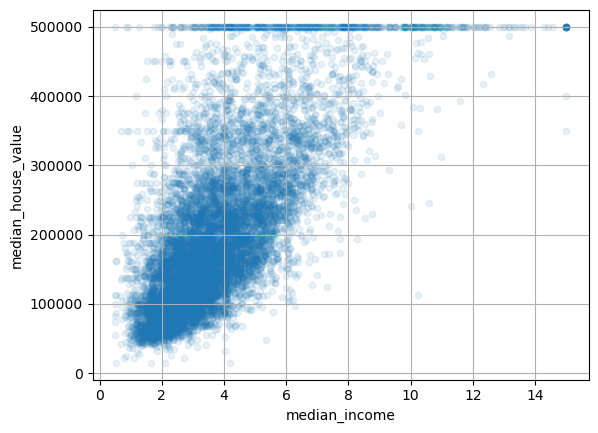

In [180]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1, grid=True)